<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Find_price_pattern_and_predict_on_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find price patterns

In [160]:
# !rm -rf /content/Predict-price-after-pattern

In [161]:
# %cd /content/

# import os
# from getpass import getpass
# user = getpass('GitHub user')
# password = getpass('GitHub password')
# os.environ['GITHUB_AUTH'] = user + ':' + password
# !git clone https://$GITHUB_AUTH@github.com/romqn1999/Predict-price-after-pattern.git
# %cd Predict-price-after-pattern

## Install packages

In [162]:
#optional installations: 
!pip install yfinance --upgrade --no-cache-dir
!pip3 install pandas_datareader

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


## Import packages

In [163]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel as C

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

## Get data

In [164]:
#@title Set symbol and time for get data
# ___variables___
ticker = "AMZN" #@param ["APPL", "SNP", "GOOG", "SPY", "BTC", "IBM", "DAX", "GME", "AMC", "BB", "TSLA", "AMZN", "FB", "NFLX"] {allow-input: true}
#ticker = 'SNP'    # SINOPEC China Petroleum and Chemical Corp 
#ticker = 'CHA'    # China Telecom
#ticker = 'CHL'    # China Mobile
#ticker = 'NGG'    # National Grid

start_time = "2000-01-01" #@param {type:"date"}
start_time = datetime.datetime.strptime(start_time, "%Y-%m-%d")
# start_time = datetime.datetime(2019, 10, 1)
#end_time = datetime.datetime(2019, 1, 20)
# end_time = datetime.datetime.now().date().isoformat()         # today
end_time = datetime.datetime.now().date().strftime("%Y-%m-%d") #@param {type:"date"}

In [165]:
def get_data_yahoo(ticker, start_time, end_time):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    ticker_df = ticker_df.reset_index()
    # print(ticker_df.head(5))
    return ticker_df

In [166]:
# # yahoo gives only daily historical data
# connected = False
# while not connected:
#     try:
#         ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
#         connected = True
#         print('connected to yahoo')
#     except Exception as e:
#         print("type error: " + str(e))
#         time.sleep( 5 )
#         pass   

# # use numerical integer index instead of date    
# ticker_df = ticker_df.reset_index()
# from get_yahoo_finance_data import get_data_yahoo
ticker_df = get_data_yahoo(ticker, start_time, end_time)
print(ticker_df)

connected to yahoo
           Date         High          Low  ...        Close    Volume    Adj Close
0    2000-01-03    89.562500    79.046875  ...    89.375000  16117600    89.375000
1    2000-01-04    91.500000    81.750000  ...    81.937500  17487400    81.937500
2    2000-01-05    75.125000    68.000000  ...    69.750000  38457400    69.750000
3    2000-01-06    72.687500    64.000000  ...    65.562500  18752000    65.562500
4    2000-01-07    70.500000    66.187500  ...    69.562500  10505400    69.562500
...         ...          ...          ...  ...          ...       ...          ...
5373 2021-05-12  3207.939941  3133.100098  ...  3151.939941   4936400  3151.939941
5374 2021-05-13  3203.840088  3133.000000  ...  3161.469971   3350900  3161.469971
5375 2021-05-14  3228.860107  3183.000000  ...  3222.899902   3321400  3222.899902
5376 2021-05-17  3292.750000  3234.590088  ...  3270.389893   3717900  3270.389893
5377 2021-05-18  3312.000000  3277.500000  ...  3283.889893   137352

## Polynomial fit
* high degree polynomials tend to oscillate significantly and will not correctly classify the dataset
* polynomials of low degree will not have local minima corresponding to double bottom

In [167]:
def polyfit(x_data, y_data, degree=80):
    # polynomial fit of degree xx
    pol = np.polyfit(x_data, y_data, degree)
    y_pol = np.polyval(pol, x_data)
    return y_pol

In [168]:
def gaussfit(x_data, y_data, max_len_per_fit=200):
    # Define kernel parameters. 
    l = 0.1
    sigma_f = 2
    # Error standard deviation. 
    sigma_n = 0.3

    # Define kernel object. 
    kernel = C(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
                * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

    # Define GaussianProcessRegressor object. 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=2)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(np.array(x_data).reshape(-1, 1), y_data)
    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pol, sigma = gp.predict(np.array(x_data).reshape(-1, 1), return_std=True)
    return y_pol

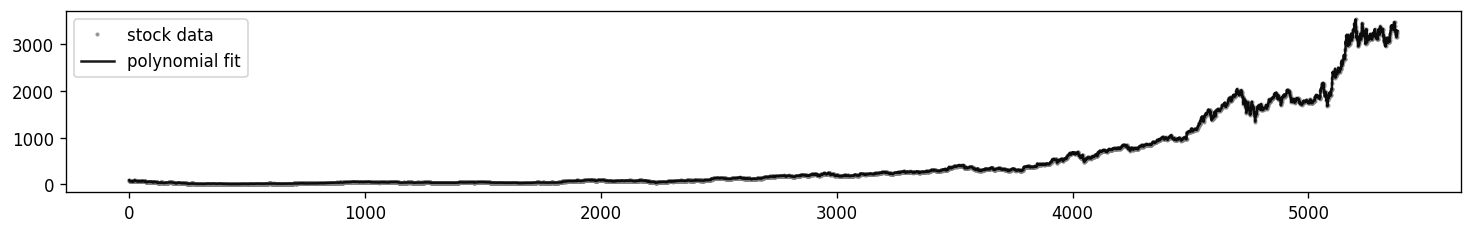

In [169]:
#@title Choose part of the OHLC (Open, High, Low, Close) dataset and fit it price
price_name = "Close" #@param ["Open", "High", "Low", "Close", "Adj Close"]

# discrete dataset
x_data = ticker_df.index.tolist()      # the index will be our x axis, not date
y_data = ticker_df[price_name]

# x values for the polynomial fit
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# from fit_data import polyfit, gaussfit
# y_pol = gaussfit(x_data, y_data)
y_pol = y_data  # no smooth

#           ___ plotting ___
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')

# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)

# plot polynomial fit
plt.plot(x_data, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()

## Detection of local extremes
Local minima are marked in red, local maxima are in blue. We will need only the minimums going forward.

In [170]:
def get_max_min(prices, smoothing, window_range, price_name='Adj Close'):
    smooth_prices = prices[price_name].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range][price_name].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range][price_name].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    # p = prices.reset_index()   
    # max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    # max_min = max_min.set_index('day_num')[price_name]
    
    return max_min

     date       Date         High  ...        Close    Volume    Adj Close
0      18 2000-01-28    66.437500  ...    61.687500  13777900    61.687500
2      22 2000-02-03    85.937500  ...    84.187500  43750000    84.187500
3      25 2000-02-08    84.000000  ...    83.125000  19472800    83.125000
5      28 2000-02-11    79.125000  ...    76.187500   8309000    76.187500
6      42 2000-03-03    64.750000  ...    62.500000   6059500    62.500000
..    ...        ...          ...  ...          ...       ...          ...
473  5299 2021-01-26  3338.000000  ...  3326.129883   2955200  3326.129883
474  5304 2021-02-02  3427.739990  ...  3380.000000   7098600  3380.000000
475  5327 2021-03-08  3064.590088  ...  2951.949951   4178500  2951.949951
476  5335 2021-03-18  3116.629883  ...  3027.989990   3649600  3027.989990
477  5364 2021-04-29  3514.449951  ...  3471.310059   7682400  3471.310059

[301 rows x 8 columns]


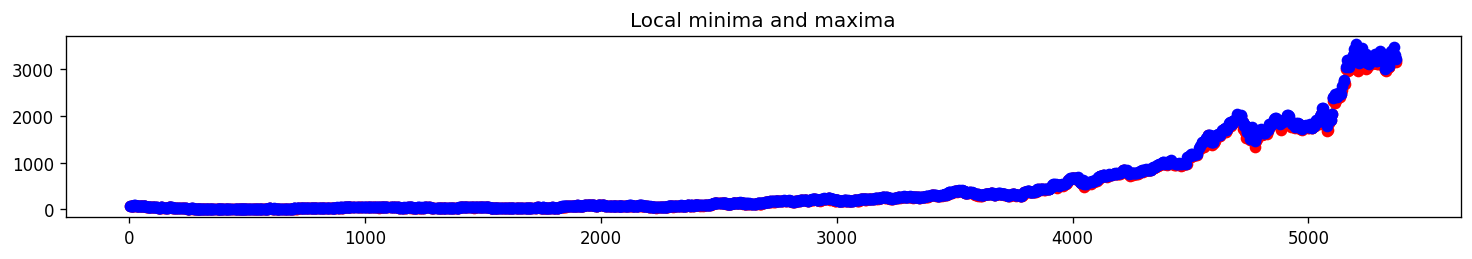

l_min:  [   3    7   10 ... 5368 5371 5373]


In [171]:
data = y_pol

#           ___ detection of local minimums and maximums ___

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
# +1 due to the fact that diff reduces the original index number
print(get_max_min(ticker_df, 20, 20, price_name=price_name))

# plot
plt.figure(figsize=(15, 2), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(x_data, data, color='grey')
plt.plot(x[l_min], data[l_min], "o", label="min", color='r')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='b')        # maxima
plt.title('Local minima and maxima')
plt.show()

print('l_min: ', l_min)

Position of local minima of the fitting function on x axis should correspond to x axis position of the minima in data. Since fitting function is just an approximation, it will be convenient to to use range of days (ticks) around the minimum. And then we would take an average value of the price for that x range to smooth the price values a bit. We will store the data in the dictionary.

In [172]:
#print('corresponding LOW values for suspected indeces: ')
#print(ticker_df.Low.iloc[l_min])

#extend the suspected x range:
delta = 10                                       # how many ticks to the left and to the right from local minimum on x axis

dict_i = dict()
dict_x = dict()

df_len = len(ticker_df.index)                    # number of rows in dataset

for element in l_min:                            # x coordinates of suspected minimums
    l_bound = element - delta                    # lower bound (left)
    u_bound = element + delta                    # upper bound (right)
    x_range = range(l_bound, u_bound + 1)        # range of x positions where we SUSPECT to find a low
    dict_x[element] = x_range                    # just helpful dictionary that holds suspected x ranges for further visualization strips
    
    #print('x_range: ', x_range)
    
    y_loc_list = list()
    for x_element in x_range:
        #print('-----------------')
        if x_element > 0 and x_element < df_len:                # need to stay within the dataframe
            #y_loc_list.append(ticker_df.Low.iloc[x_element])   # list of suspected y values that can be a minimum
            y_loc_list.append(ticker_df[price_name].iloc[x_element])
            #print(y_loc_list)
            #print('ticker_df.Low.iloc[x_element]', ticker_df.Low.iloc[x_element])
    dict_i[element] = y_loc_list                 # key in element is suspected x position of minimum
                                                 # to each suspected minimums we append the price values around that x position
                                                 # so 40: [53.70000076293945, 53.93000030517578, 52.84000015258789, 53.290000915527344]
                                                 # x position: [ 40$, 39$, 41$, 45$]
#print('DICTIONARY for l_min: ', dict_i)

Finally when we have x range and y price range identified we can compare the suspected low prices. Also, since we are looking for global minima we set a threshold that is in certain percentage range higher than the lowest datapoint in the dataset. This can be optionally improved by an average of several lowest values to mitigate impact of an outlier value.

## Find pattern

In [173]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.1 #@param {type:"number"}
def is_trend(x_data, y_data):
    if len(x_data) < 2:
        return False
    p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    err = res[0] if res.size > 0 else 0
    if err <= len(x_data) * trend_delta:
        return True
    return False

In [174]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}
threshold = min(ticker_df[price_name]) * 1.15      # setting threshold higher than the global low

### Double top detection

In [175]:
#@title Double top detection

def find_key_points(x_data, y_data):
    key_points = [0]
    n = len(x_data)
    i = 0
    j = 2
    while j + 1 < n:
        p, res, _, _, _ = np.polyfit(x_data[i : j + 1], y_data[i : j + 1], 1, full=True)
        if res[0] > (j - i + 1) * trend_delta:
            key_points.append(j - 1)
            i = j - 1
        j += 1
    key_points.append(j - 1)
    # # ___ plotting ___
    # plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # # plot stock data
    # plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

    # # plot polynomial fit
    # plt.plot(np.array(x_data)[key_points], np.array(y_data)[key_points], '-', markersize=1.0, color='black', alpha=0.9)

    # plt.show()
    return key_points

# find_double_top(x_data, y_data)

l_min_max = sorted(np.append(l_min, l_max))
x_l_min_max = np.array(x_data)[l_min_max]
y_l_min_max = np.array(y_data)[l_min_max]

find_key_points(x_l_min_max, y_l_min_max)

def find_double_top(x_data, y_data, key_points):
    suspected_double_tops = list()
    # for i in range(1, len(key_points) - 2):
    #     for j in range(i + 1, len(key_points) - 1):
    #         l = key_points[i]
    #         r = key_points[j]
    #         if abs(y_data[l] - y_data[r]) <= y_delta \
    #             and y_data[l] >= max(data[l + 1: r]) \
    #             and y_data[r] >= max(data[l + 1: r]):
    #             k_min = l
    #             for k in range(l + 1, r):
    #                 if y_data[k] < y_data[k_min]:
    #                     k_min = k
    #             if (y_data[key_points[i - 1]] < y_data[k_min]) \
    #                 and y_data[key_points[j + 1]] < y_data[k_min]:
    #                 suspected_double_tops.append((i, j, k_min))
    assert len(x_data) == len(y_data)
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

# find_double_top(x_data, y_pol, l_min_max)

### Double bottom detection

In [176]:
def find_double_bottom(x_data, y_data, key_points):
    assert len(x_data) == len(y_data)
    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

# find_double_bottom(x_data, y_pol, l_min_max)

In [177]:
# y_delta = 0.12                               # percentage distance between average lows
# threshold = min(ticker_df[price_name]) * 1.15      # setting threshold higher than the global low

# y_dict = dict()
# mini = list()
# suspected_bottoms = list()
#                                               #   BUG somewhere here
# for key in dict_i.keys():                     # for suspected minimum x position  
#     mn = sum(dict_i[key])/len(dict_i[key])    # this is averaging out the price around that suspected minimum
#                                               # if the range of days is too high the average will not make much sense
        
#     price_min = min(dict_i[key])
#     price_max_left = max(dict_i[key][:len(dict_i[key]) // 2])
#     price_max_right = max(dict_i[key][len(dict_i[key]) // 2:])
#     mini.append(price_min)                    # lowest value for price around suspected 
    
#     l_y = mn * (1.0 - y_delta)                #these values are trying to get an U shape, but it is kinda useless 
#     u_y = mn * (1.0 + y_delta)
#     y_dict[key] = [l_y, u_y, mn, price_min, price_max_left, price_max_right]
    
# #print('y_dict: ') 
# #print(y_dict) 

# #print('SCREENING FOR DOUBLE BOTTOM:')    
    
# for key_i in y_dict.keys():    
#     for key_j in y_dict.keys():    
#         if (key_i != key_j) and (y_dict[key_i][3] < threshold):
#             suspected_bottoms.append(key_i)

# suspected_double_bottoms = list()
# for i in range(max(y_dict.keys())):
#     if i in y_dict:
#         for j in range(i + 2, max(y_dict.keys())):
#             if j in y_dict and abs(data[i] - data[j]) <= y_delta and data[i] <= min(data[i + 1: j]) and data[j] <= min(data[i + 1: j]):
#                 k_max = i
#                 for k in range(i + 1, j):
#                     if data[k] > data[k_max]:
#                         k_max = k
#                 if (y_dict[i][4] > data[k_max]) and y_dict[j][5] > data[k_max]:
#                     suspected_double_bottoms.append((i, j, k_max))

### Inverse head and shoulder detection

In [178]:
def find_IHS_patterns(data, l_min, l_max):  
    patterns = list()
    
    i = 0  # index in l_min off first shoulder from left to right
    j = 0  # index in l_max off first point on neckle line fron left to right
    while i <= len(l_min) - 3 and j <= len(l_max) - 2:
        while j <= len(l_max) - 2 and  l_max[j] < l_min[i]:
            j += 1
        if j > len(l_max) - 2:
            break
        ia, ib, ic, id, ie = l_min[i], l_max[j], l_min[i + 1], l_max[j + 1], l_min[i + 2]
        a, b, c, d, e = data[ia], data[ib], data[ic], data[id], data[ie]
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
            patterns.append((ia, ib, ic, id, ie))
        i += 1
        
    return patterns

suspected_ihs = find_IHS_patterns(data, l_min, l_max)
print(suspected_ihs)

[(48, 49, 50, 51, 53), (219, 221, 225, 227, 229), (249, 250, 252, 253, 255), (341, 342, 343, 346, 347), (405, 407, 409, 411, 412), (427, 429, 435, 430, 442), (700, 705, 708, 711, 713), (734, 735, 736, 739, 740), (787, 788, 790, 791, 792), (822, 823, 824, 827, 829), (843, 845, 847, 849, 850), (856, 858, 859, 863, 864), (866, 867, 869, 870, 872), (1232, 1235, 1238, 1240, 1241), (1361, 1362, 1364, 1365, 1367), (1433, 1434, 1437, 1440, 1441), (1489, 1490, 1492, 1495, 1496), (1500, 1502, 1507, 1503, 1509), (1534, 1535, 1536, 1538, 1539), (1550, 1551, 1553, 1554, 1555), (1561, 1562, 1565, 1568, 1570), (1576, 1578, 1579, 1581, 1585), (1649, 1651, 1654, 1656, 1659), (1687, 1688, 1689, 1692, 1694), (1769, 1770, 1772, 1773, 1775), (1796, 1797, 1800, 1801, 1803), (1841, 1843, 1844, 1846, 1847), (1875, 1876, 1879, 1881, 1882), (1910, 1912, 1914, 1916, 1917), (1920, 1921, 1923, 1924, 1925), (1996, 1998, 2000, 2004, 2005), (2063, 2065, 2069, 2072, 2073), (2086, 2087, 2088, 2090, 2092), (2153, 2154, 

### Final visualization

[3, 4, 7, 8, 10, 11, 13, 14, 16, 17, 18, 22, 24, 25, 27, 28, 34, 35, 36, 37, 38, 39, 42, 43, 44, 46, 48, 49, 50, 51, 53, 54, 56, 58, 60, 62, 63, 64, 65, 67, 68, 69, 72, 74, 77, 79, 80, 82, 84, 86, 87, 88, 89, 90, 91, 94, 98, 99, 100, 102, 103, 105, 107, 110, 111, 112, 116, 117, 120, 123, 125, 126, 128, 129, 131, 132, 133, 134, 135, 136, 138, 139, 144, 150, 153, 157, 158, 159, 161, 164, 165, 167, 168, 169, 171, 174, 175, 176, 177, 181, 183, 186, 187, 190, 191, 194, 195, 197, 198, 200, 203, 205, 207, 209, 212, 214, 215, 219, 221, 225, 227, 229, 230, 232, 233, 236, 239, 241, 242, 246, 248, 249, 250, 252, 253, 255, 264, 265, 267, 268, 270, 274, 276, 279, 280, 281, 283, 286, 287, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 303, 306, 307, 308, 310, 312, 313, 316, 317, 318, 322, 323, 325, 327, 328, 329, 330, 332, 335, 336, 337, 341, 342, 343, 346, 347, 348, 350, 353, 354, 356, 359, 360, 368, 370, 371, 375, 376, 377, 378, 379, 380, 381, 383, 385, 386, 387, 388, 390, 393, 3

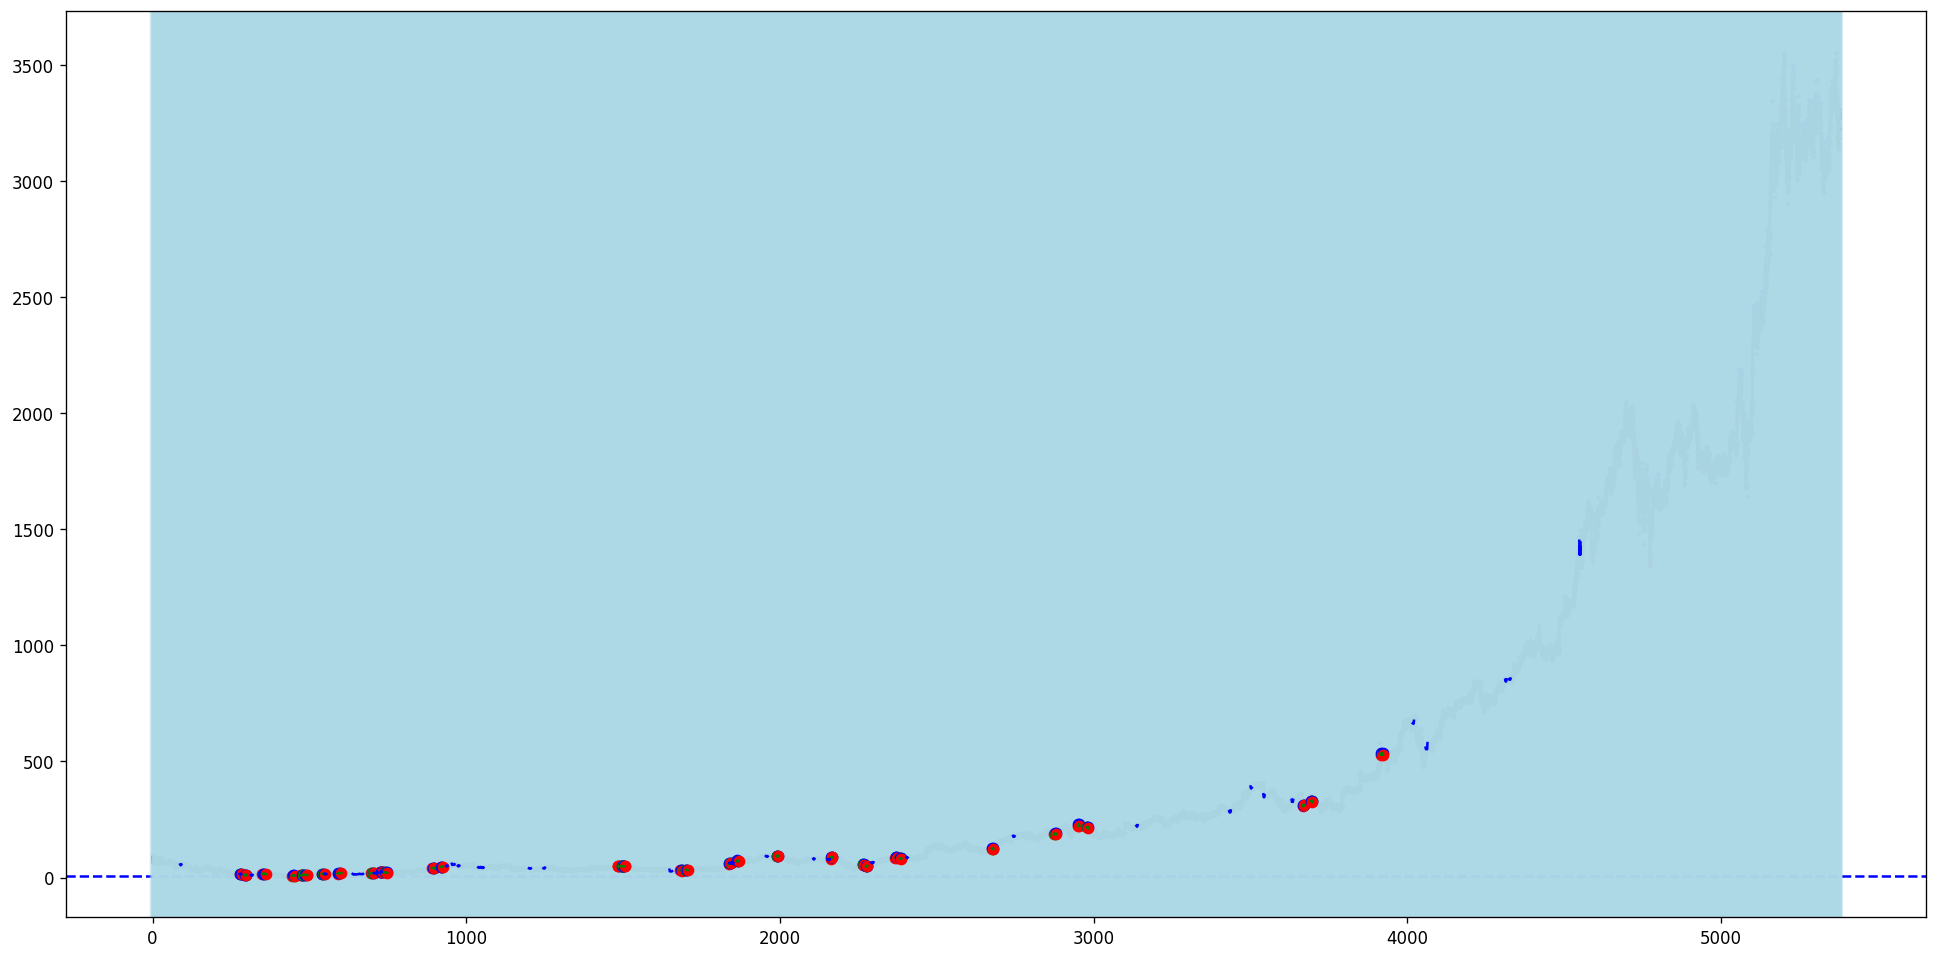

In [179]:
# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=1.5, color='magenta', alpha=0.7)

# we can plot also all the other prices to get a price range for given day just for information
plt.plot(x_data, ticker_df['High'],      'o', markersize=1.5, color='blue',  alpha=0.7)
plt.plot(x_data, ticker_df['Open'],      'o', markersize=1.5, color='grey',  alpha=0.7)
plt.plot(x_data, ticker_df['Close'],     'o', markersize=1.5, color='red', alpha=0.7)    # Adj Close should be more accurate indication (accounts for dividends and stock splits)
plt.plot(x_data, ticker_df['Adj Close'], 'o', markersize=1.5, color='green', alpha=0.4)


# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)

# for position in suspected_bottoms:
#     plt.axvline(x=position, linestyle='-.', color='r')

# for bottom1, bottom2, top in suspected_double_bottoms:
#     plt.axvline(x=bottom1, linestyle='-.', color='b')
#     plt.axvline(x=top, linestyle='-.', color='g')
#     plt.axvline(x=bottom2, linestyle='-.', color='b')

# for ia, ib, ic, id, ie in suspected_ihs:
#     plt.axvline(x=ia, linestyle='-.', color='b')
#     plt.axvline(x=ib, linestyle='-.', color='g')
#     plt.axvline(x=ic, linestyle='-.', color='b')
#     plt.axvline(x=id, linestyle='-.', color='g')
#     plt.axvline(x=ie, linestyle='-.', color='b')
    
plt.axhline(threshold, linestyle='--', color='b')    


for key in dict_x.keys():
    #print('dict key value: ', dict_i[key])
    for value in dict_x[key]:
        plt.axvline(x=value, linestyle='-', color = 'lightblue', alpha=0.2)

l_min_max = sorted(np.append(l_min, l_max))
x_l_min_max = np.array(x_data)[l_min_max]
y_l_min_max = np.array(y_data)[l_min_max]
key_points = find_key_points(x_l_min_max, y_l_min_max)
key_points = np.array(l_min_max)[key_points]
# plt.plot(np.array(x_data)[key_points], np.array(y_data)[key_points], '-', markersize=1.0, color='b', alpha=0.9)

# suspected_double_tops = find_double_top(x_data, y_pol, key_points)
print(l_min_max)
suspected_double_tops = find_double_top(x_data, y_pol, l_min_max)
print(suspected_double_tops)

for istart, top1, bottom, top2, iend in suspected_double_tops:
    plt.plot(x_data[istart], y_pol[istart], "o", color='r')
    plt.plot(x_data[top1], y_pol[top1], "o", color='b')
    plt.plot(x_data[bottom], y_pol[bottom], "o", color='g')
    plt.plot(x_data[top2], y_pol[top2], "o", color='b')
    plt.plot(x_data[iend], y_pol[iend], "o", color='r')
    plt.plot(np.array(x_data)[[istart, top1, bottom, top2, iend]], np.array(y_pol)[[istart, top1, bottom, top2, iend]], "-", color='g')

suspected_double_bottoms = find_double_bottom(x_data, y_pol, l_min_max)
for istart, bot1, top, bot2, iend in suspected_double_bottoms:
    plt.plot(np.array(x_data)[[istart, bot1, top, bot2, iend]], np.array(y_pol)[[istart, bot1, top, bot2, iend]], "-", color='b')

plt.show()

# print('dict_x: ', dict_x)   # this dictionary is holding the values of the suspected low price
# print('y_dict:', y_dict)

- vertical red lines:            suspected double(multiple) minimums
- horizontal blue line:          price threshold for detection, we consider ONLY prices below this value
- vertical light blue strips:    areas around local minimums in polynomial fit

- green dots:                    'Adj Close' price, this might be shifted from rest of the price dataset (correction for stock splits and dividends), possibly even better for detecting double bottoms (needs to be tested further). In this notebook we used only 'Low' price.

So double (multiple) bottom is detected only when 'Low' price is below horizontal blue line and inside light blue strip. Position of the blue line threshold and width of the strip are set as constants.

# Predict with LSTM

## Import packages

In [180]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

## Get data at pattern for training

Find all patterns and sort by last index of pattern

In [181]:
# suspected_double_tops = find_double_top(x_data, y_pol, l_min_max)
# suspected_double_bottoms = find_double_bottom(x_data, y_pol, l_min_max)
suspected_patterns = suspected_double_tops + suspected_double_bottoms
suspected_patterns = sorted(suspected_patterns, key=lambda p: p[-1])
print(suspected_patterns)

[(88, 89, 90, 91, 92), (277, 279, 280, 281, 283), (279, 280, 281, 283, 284), (293, 294, 297, 298, 299), (313, 316, 317, 318, 319), (350, 353, 354, 356, 362), (444, 447, 450, 452, 453), (474, 475, 480, 483, 493), (474, 475, 480, 486, 493), (540, 541, 544, 546, 549), (548, 550, 551, 553, 554), (590, 592, 597, 599, 602), (638, 641, 644, 648, 657), (662, 664, 666, 670, 671), (696, 699, 700, 705, 707), (705, 708, 711, 713, 718), (711, 713, 716, 717, 718), (725, 727, 728, 729, 730), (727, 728, 729, 730, 731), (724, 727, 730, 731, 734), (736, 741, 744, 746, 748), (891, 894, 896, 897, 898), (920, 921, 922, 923, 925), (936, 937, 938, 939, 941), (954, 955, 959, 962, 963), (973, 974, 975, 977, 978), (1038, 1039, 1041, 1044, 1046), (1049, 1051, 1052, 1053, 1055), (1200, 1202, 1203, 1204, 1206), (1246, 1247, 1249, 1250, 1251), (1484, 1490, 1492, 1495, 1500), (1483, 1497, 1500, 1502, 1505), (1483, 1497, 1500, 1503, 1505), (1648, 1649, 1651, 1654, 1656), (1681, 1685, 1687, 1688, 1689), (1700, 1701, 1

In [182]:
#@title Get data at patterns
pre_time_steps = 30 #@param {type:"integer"}

price_patterns_df = pd.DataFrame()
last = -1
for pattern in suspected_patterns:
    # if 2 patterns have same end point then only use 1 skip other
    # if last == pattern[-1]:
    #     continue
    last = pattern[-1]
    if last < pre_time_steps or last + 1 >= len(x_data):
        continue
    prices = np.array(y_data).reshape(-1, 1)[last - pre_time_steps + 1 : last + 2]
    price_patterns_df = price_patterns_df.append(pd.DataFrame(prices).T)

price_patterns_df.to_csv("{}_{}_{}_{}_data_patterns.csv"
                         .format(ticker, start_time, end_time, pre_time_steps),
                        #  sep=' ',
                         index=False,
                         header=False)

price_patterns_df = pd.read_csv("{}_{}_{}_{}_data_patterns.csv"
                                .format(ticker, start_time, end_time, pre_time_steps),
                                # sep=' ',
                                header=None)
price_patterns_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,63.562500,63.937500,62.187500,64.250000,67.562500,63.375000,63.375000,56.375000,48.000000,46.875000,47.062500,54.937500,53.437500,52.375000,49.812500,52.437500,53.500000,52.875000,55.187500,59.937500,56.125000,54.125000,55.062500,58.500000,56.015625,56.250000,53.312500,54.875000,53.750000,56.062500,59.062500
1,15.500000,14.562500,14.937500,16.375000,16.500000,17.000000,17.687500,18.062500,18.375000,19.500000,19.937500,18.500000,18.953125,21.875000,19.000000,19.500000,20.125000,18.937500,17.312500,16.250000,14.375000,14.437500,15.812500,15.000000,14.375000,13.375000,14.500000,13.750000,14.437500,14.500000,13.687500
2,14.562500,14.937500,16.375000,16.500000,17.000000,17.687500,18.062500,18.375000,19.500000,19.937500,18.500000,18.953125,21.875000,19.000000,19.500000,20.125000,18.937500,17.312500,16.250000,14.375000,14.437500,15.812500,15.000000,14.375000,13.375000,14.500000,13.750000,14.437500,14.500000,13.687500,12.500000
3,20.125000,18.937500,17.312500,16.250000,14.375000,14.437500,15.812500,15.000000,14.375000,13.375000,14.500000,13.750000,14.437500,14.500000,13.687500,12.500000,11.937500,11.937500,11.812500,11.937500,11.750000,10.187500,10.437500,10.000000,12.625000,11.875000,12.250000,11.687500,12.250000,10.625000,11.000000
4,11.750000,10.187500,10.437500,10.000000,12.625000,11.875000,12.250000,11.687500,12.250000,10.625000,11.000000,10.625000,10.875000,11.000000,10.500000,10.250000,10.000000,10.187500,10.187500,10.940000,11.640000,10.800000,10.000000,10.230000,9.100000,8.630000,8.400000,9.120000,8.370000,11.180000,12.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,642.349976,647.809998,643.299988,663.539978,661.270020,668.450012,678.989990,671.150024,675.340027,673.260010,664.799988,679.059998,676.010010,666.250000,672.640015,669.830017,677.330017,664.789978,662.320007,640.150024,657.909973,658.640015,675.770020,670.650024,664.140015,664.510010,663.150024,663.700012,662.789978,675.200012,693.969971
66,574.479980,571.770020,575.020020,596.380005,596.530029,601.250000,583.349976,635.349976,587.000000,574.809998,552.099976,531.070007,536.260010,502.130005,488.100006,482.070007,490.480011,503.820007,507.079987,521.099976,534.099976,525.000000,534.900024,559.500000,552.940002,554.039978,555.150024,555.229980,552.520020,579.039978,580.210022
67,807.479980,809.039978,808.330017,817.880005,822.440002,836.520020,839.150024,835.770020,830.380005,823.479980,832.349976,839.950012,810.200012,807.640015,812.500000,819.710022,821.359985,827.460022,836.530029,836.390015,842.700012,844.140015,845.070007,856.440002,855.609985,852.190002,845.239990,848.640015,845.039978,853.080017,848.909973
68,807.640015,812.500000,819.710022,821.359985,827.460022,836.530029,836.390015,842.700012,844.140015,845.070007,856.440002,855.609985,852.190002,845.239990,848.640015,845.039978,853.080017,848.909973,849.880005,846.609985,846.020020,850.500000,853.000000,852.460022,854.590027,852.530029,852.969971,853.419983,852.309998,856.969971,843.200012


In [ ]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

             0           1           2   ...          27          28          29
0      5.032500    4.680357    4.530000  ...    3.568214    3.733929    3.965714
1      3.575000    3.466786    3.505000  ...    3.424286    3.384643    3.218571
2      3.064643    3.093214    3.081786  ...    3.445000    3.561429    3.661071
3      3.064643    3.093214    3.081786  ...    3.445000    3.561429    3.661071
4      3.064643    3.093214    3.081786  ...    3.445000    3.561429    3.661071
..          ...         ...         ...  ...         ...         ...         ...
106   71.762497   71.107498   71.672501  ...   79.212502   79.722504   79.182503
107   69.232498   67.092499   69.025002  ...   79.562500   79.485001   80.462502
108   76.927498   78.739998   78.285004  ...   90.014999   91.209999   88.407501
109  110.440002  114.949997  119.029999  ...  122.410004  121.779999  127.879997
110  129.710007  129.869995  126.000000  ...  121.389999  119.900002  122.150002

[111 rows x 30 columns]
   

In [ ]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(88, 30) (88, 1)
(88, 30) (88, 1)
(23, 30) (23, 1)
(23, 30) (23, 1)


In [ ]:
# # Feature Scaling
# sc = MinMaxScaler(feature_range = (0, 1))
# y_data_scaled = sc.fit_transform(np.array(y_data).reshape(-1, 1))
# price_patterns_df_scaled = pd.DataFrame(sc.fit_transform(price_patterns_df.T).T,columns=price_patterns_df.columns)

In [ ]:
# X_train = []
# y_train = []
# # for pattern in suspected_patterns:
# #     last = pattern[-1]
# #     if last < pre_time_steps or last + 1 >= len(x_data):
# #         continue
# #     X_train.append(y_data_scaled[last - pre_time_steps + 1 : last + 1])
# #     y_train.append(y_data_scaled[last + 1])
# # if scale_method == 'None':
# data = price_patterns_df.values
# if scale_method == 'MinMax':
#     # scs = []
#     # price_patterns_scaled_df = price_patterns_df.copy()
#     # for i, row in price_patterns_scaled_df.iterrows():
#     #     print(i, row)
#     #     sc = MinMaxScaler(feature_range = (0, 1))
#     #     scaled_val = sc.fit_transform(np.array(row).reshape(-1, 1)).reshape(-1)
#     #     print(i, scaled_val)
#     #     price_patterns_scaled_df.loc[i] = scaled_val
#     #     scs.append(sc)
#     # data = price_patterns_scaled_df.values
#     sc_train = MinMaxScaler(feature_range = (0, 1))
#     # price_patterns_scaled_df = 
#     data = price_patterns_df_scaled.values
# # separate into input and output columns
# X_train, y_train = data[:, :-1], data[:, -1]
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# y_train = np.reshape(y_train, (y_train.shape[0], 1))
# print(X_train)
# print(y_train)

## LSTM model

### Build model

In [ ]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 8000 #@param {type:"integer"}
batch_size = 512 #@param {type:"integer"}

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True,
               input_shape=(pre_time_steps, 1)))
model.add(Dropout(dropout_prob))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True))
model.add(Dropout(dropout_prob))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units,
               return_sequences=True))
model.add(Dropout(dropout_prob))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
# Adding the output layer
model.add(Dense(units=1))

# Adam optimizer
opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
# # PiecewiseConstantDecay optimizer
# boundaries = [200, 800, 2000, 4000]
# values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
# opt = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# Compiling the RNN
# model.compile(optimizer = opt, loss = 'mean_squared_error')
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Train model

In [ ]:
def train_lstm(model, X_train, y_train, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))

    # Fitting the RNN to the Training set
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return model

model = train_lstm(model, X_train_scaled, y_train_scaled, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
Epoch 5501/8000
1/1 [==============================] - 0s 89ms/step - loss: 0.0059
Epoch 5502/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0033
Epoch 5503/8000
1/1 [==============================] - 0s 89ms/step - loss: 0.0041
Epoch 5504/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0048
Epoch 5505/8000
1/1 [==============================] - 0s 88ms/step - loss: 0.0045
Epoch 5506/8000
1/1 [==============================] - 0s 99ms/step - loss: 0.0047
Epoch 5507/8000
1/1 [==============================] - 0s 82ms/step - loss: 0.0055
Epoch 5508/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0037
Epoch 5509/8000
1/1 [==============================] - 0s 81ms/step - loss: 0.0043
Epoch 5510/8000
1/1 [==============================] - 0s 90ms/step - loss: 0.0040
Epoch 5511/8000
1/1 [==============================] - 0s 91ms/step - loss: 0.0040
Epoch 5512/8000
1/1 [===============

### Test model

In [ ]:
# X_test = X_train

In [ ]:
predicted_stock_price = model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
y_test, predicted_stock_price

(array([[ 37.25999832],
        [ 42.33000183],
        [ 42.92499924],
        [ 43.63499832],
        [ 41.84249878],
        [ 42.09500122],
        [ 47.64500046],
        [ 47.64500046],
        [ 54.56000137],
        [ 55.54750061],
        [ 54.82749939],
        [ 52.18500137],
        [ 54.68000031],
        [ 56.14749908],
        [ 64.86250305],
        [ 65.43499756],
        [ 64.85749817],
        [ 69.23249817],
        [ 79.52749634],
        [ 80.83499908],
        [ 90.44499969],
        [127.80999756],
        [123.        ]]), array([[ 37.25608 ],
        [ 41.91061 ],
        [ 43.775925],
        [ 42.86752 ],
        [ 41.15305 ],
        [ 41.838863],
        [ 46.985054],
        [ 46.985054],
        [ 54.541183],
        [ 54.76781 ],
        [ 55.487705],
        [ 48.97741 ],
        [ 52.752346],
        [ 51.264862],
        [ 63.415447],
        [ 63.582214],
        [ 60.84968 ],
        [ 69.88919 ],
        [ 73.5813  ],
        [ 74.58006 ],
       

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.00]
 [0.42]
 [-0.85]
 [0.77]
 [0.69]
 [0.26]
 [0.66]
 [0.66]
 [0.02]
 [0.78]
 [-0.66]
 [3.21]
 [1.93]
 [4.88]
 [1.45]
 [1.85]
 [4.01]
 [-0.66]
 [5.95]
 [6.25]
 [2.66]
 [9.43]
 [0.92]]
[9.43]


In [ ]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)

rmse, mape

(3.1973564825400995, 3.0108005908801307)

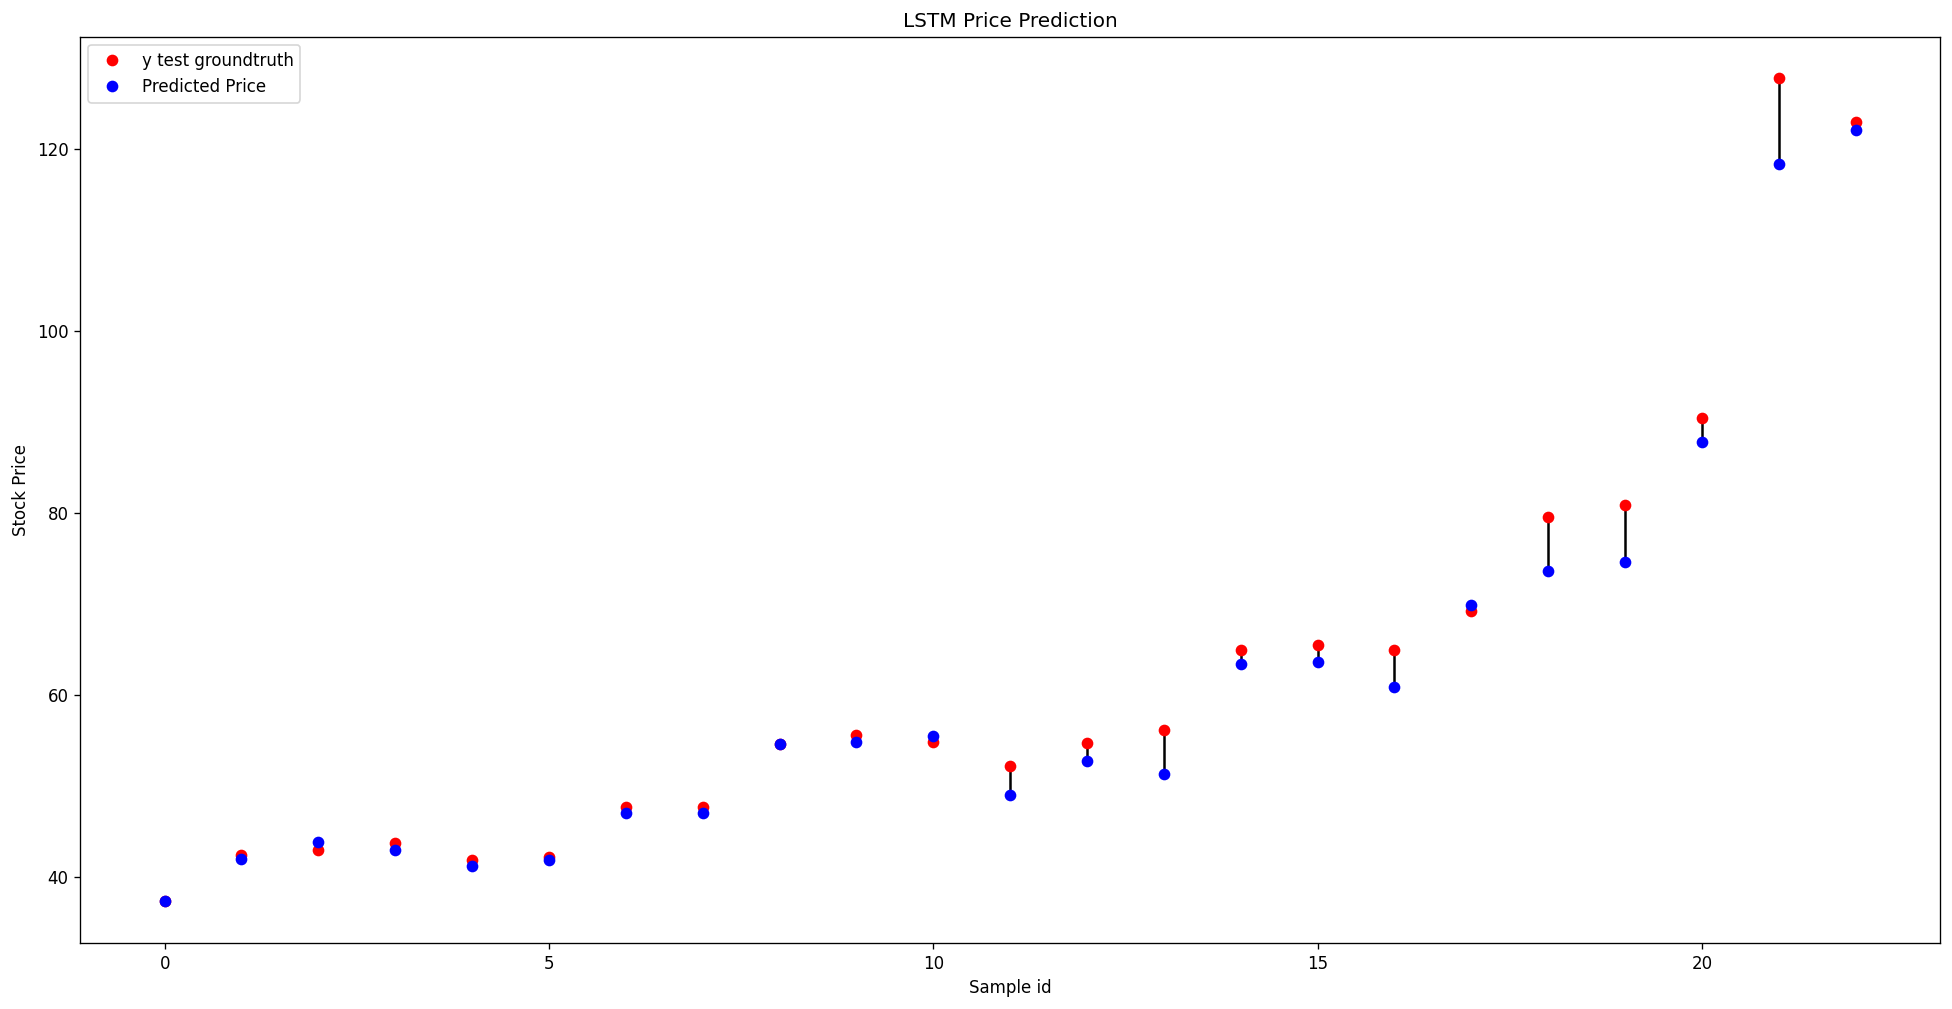

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [ ]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [ ]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[16:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [ ]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.00]
 [-0.69]
 [-0.89]
 [-0.51]
 [0.47]
 [-1.02]
 [0.54]
 [0.54]
 [-0.24]
 [-0.67]
 [0.88]
 [-0.47]
 [0.31]
 [-0.38]
 [-1.20]
 [-0.56]
 [-1.84]
 [-0.01]
 [0.45]
 [1.39]
 [1.68]
 [-1.31]
 [-0.55]]
[1.84]


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)

rmse, mape

(0.8649963453114076, 1.185532579553107)

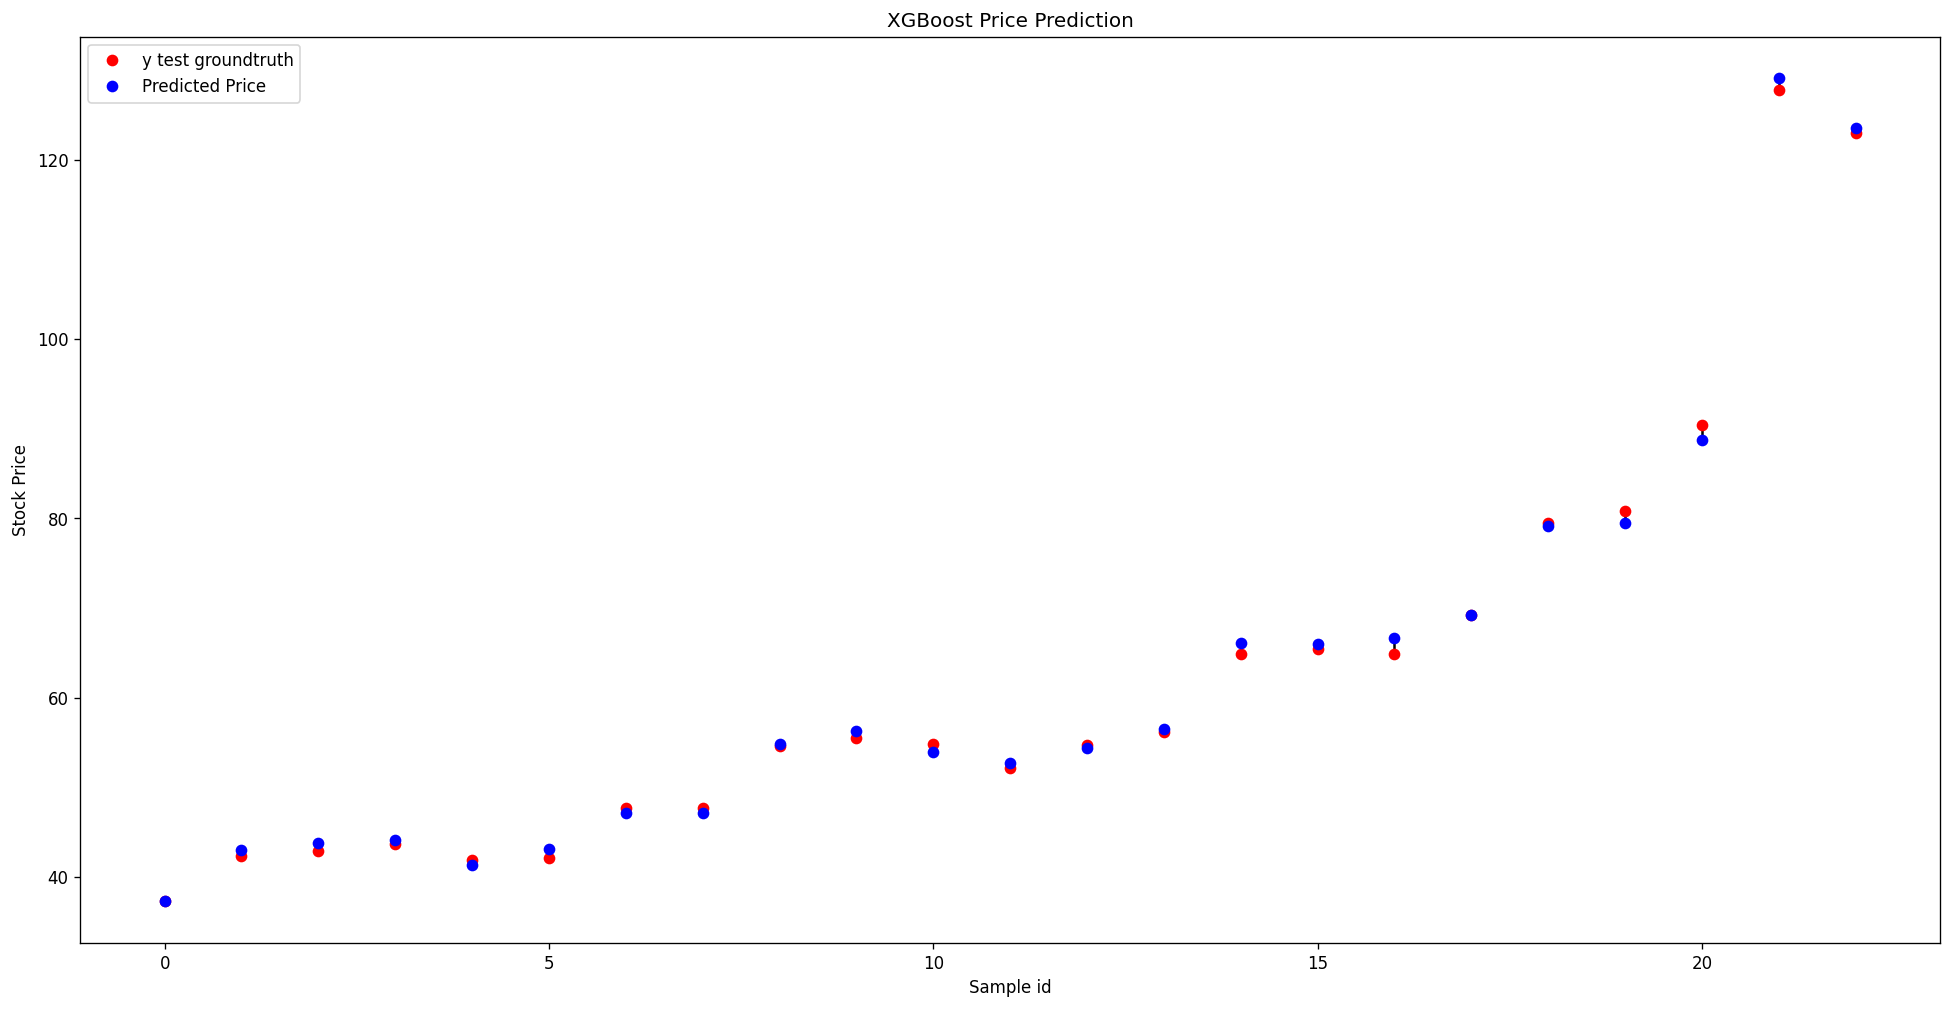

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()